In [1]:
%%capture
!pip install transformers

In [2]:
import re
import string
import torch
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import transformers

import pandas as pd
import numpy as np

import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import trange
import random

In [3]:
sns.set(rc={"figure.figsize": (7, 5)})
sns.set(font_scale=1)
sns.set_style("darkgrid")
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

In [4]:
data = pd.read_csv("word_order.csv")

In [5]:
data["target_integer"] = data["target"].replace(["SOV", "SVO", "No dominant order"], [0, 1, 2])
data = data.loc[data["target_integer"].isin([0, 1, 2])]
data = data.reset_index(drop=True)


data_0s = data.loc[data["target_integer"] == 0]
data_rest = data.loc[data["target_integer"].isin([1, 2])]

data = data_0s.head(200).append(data_rest)#.sample(frac = 1)
data = data.reset_index(drop=True)

index_list = np.array(data.index)
np.random.shuffle(np.reshape(index_list, (-1, 5)))

data = data.loc[index_list, :]
data = data.reset_index(drop=True)

text = data["extracted"]
labels = data["target_integer"]
data.head(20)

<ipython-input-5-0dbc3cf532ac>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_0s.head(200).append(data_rest)#.sample(frac = 1)


,language,extracted,enough information,target,ChatGPT,ChatGPT target,ChatGPT mistake,disrepancy,comment,target_integer
0,Temiar,"(Additionally,\nmany word-classes may function...",0.0,SVO,Based on the given paragraph from the descript...,Not enough information,0,0,NaN,1
1,Temiar,-;.jamo? 'mosquito'\n nama -;.damah 'name'\n n...,0.0,SVO,The paragraph from the descriptive grammar doe...,Not enough information,0,0,in order to,1
2,Temiar,In verb phrases the pronoun takes the bound\nf...,0.0,SVO,Based on the information provided in the parag...,Not enough information,0,0,упоминание порядка слов,1
3,Temiar,The\nbasic word-order of Temiar is subject + ...,1.0,SVO,"According to the paragraph, the basic word ord...",SVO,0,0,NaN,1
4,Temiar,This some-\n times allows a distinction to be ...,0.0,SVO,"Based on the given paragraph, there is not eno...",Not enough information,0,0,порядок клитик,1
5,Mikasuki,"Word\norder in sentences tends to be subject,...",1.0,SOV,Based on the information provided in the parag...,SOV,0,0,NaN,0
6,Mikasuki,Negative and affirmative sentences; word order...,0.0,SOV,"Based on the information provided, it is not p...",Not enough information,0,0,упоминание порядка слов,0
7,Mikasuki,The classes are ordered as they are ordered\n...,0.0,SOV,"Based on the given information, it is ""Not eno...",Not enough information,0,0,порядок аффиксов,0
8,Mikasuki,The usual order of sentence elements is (subje...,1.0,SOV,"Based on the given information, the dominant w...",SVO,1,0,NaN,0
9,Mikasuki,There are five order classes of verbal\n prefi...,0.0,SOV,"Based on the given information, the text does ...",Not enough information,0,0,порядок аффиксов,0


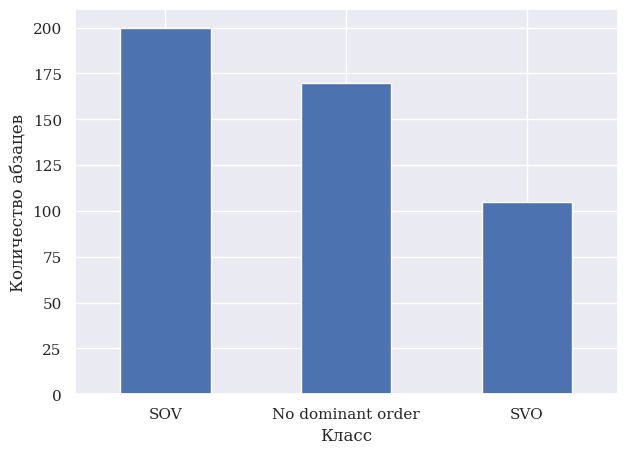

In [6]:
plt.figure()
pd.value_counts(data["target"]).plot.bar()
plt.xlabel("Класс")
plt.ylabel("Количество абзацев")
plt.xticks(rotation=360)
plt.show()

Загружаем токенизатор.

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", do_lower_case = False)

Выводим на экран токены и их индексы из случайного предложения:

In [8]:
def print_rand_sentence():
    '''Displays the tokens and respective IDs of a random text sample'''
    index = random.randint(0, len(text)-1)
    table = np.array([tokenizer.tokenize(text[index]), 
                      tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
    print(tabulate(table,
                  headers = ["Tokens", "Token IDs"],
                  tablefmt = "fancy_grid"))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ In       │       10167 │
├──────────┼─────────────┤
│ any      │       11178 │
├──────────┼─────────────┤
│ sequence │       30265 │
├──────────┼─────────────┤
│ ,        │         117 │
├──────────┼─────────────┤
│ af       │       10452 │
├──────────┼─────────────┤
│ ##fix    │       57014 │
├──────────┼─────────────┤
│ ##es     │       10171 │
├──────────┼─────────────┤
│ occur    │       32728 │
├──────────┼─────────────┤
│ in       │       10106 │
├──────────┼─────────────┤
│ the      │       10105 │
├──────────┼─────────────┤
│ numeri   │       67800 │
├──────────┼─────────────┤
│ ##cal    │       15794 │
├──────────┼─────────────┤
│ order    │       12990 │
├──────────┼─────────────┤
│ of       │       10108 │
├──────────┼─────────────┤
│ their    │       10455 │
├──────────┼─────────────┤
│ decade   │       35858 │
├──────────┼─────────────┤
│ class    │       13596 │
├──────────┼─────────────┤
│

Предобработка текста для BERT:
1. Добавить специальные токены:
- [CLS]: в начало предложения (ID 101)
- [SEP]: в конце предложения (ID 102)
2. Привести предложения к одинаковой длине с помощью паддинга.
- [PAD]: несколько раз в конец предложения (ID 0).
- Максимальная длина предложения – 512 tokens.
3. Создать маску внимания:
- Список 0 и 1, показывающих, должна ли модель рассматривать эти токены.
- [PAD] токены обозначаются 0.

In [9]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
    '''
    Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
      - input_ids: list of token ids
      - token_type_ids: list of token type ids
      - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
    '''
    return tokenizer.encode_plus(
                          input_text,
                          add_special_tokens = True,
                          max_length = 512, 
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt',
                          truncation=True
                    )

for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Выводим случайное предложение (уже с масками внимания):

In [10]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ["Tokens", "Token IDs", "Attention Mask"],
                 tablefmt = "fancy_grid"))

print_rand_sentence_encoding()

╒═════════════╤═════════════╤══════════════════╕
│ Tokens      │   Token IDs │   Attention Mask │
╞═════════════╪═════════════╪══════════════════╡
│ [CLS]       │         101 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ 4           │         125 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ .           │         119 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ 1           │         122 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ .           │         119 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ 1           │         122 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ .           │         119 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ Word        │       34368 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ order       │       12990 │                1 │
├─────────────┼─────

Разделим выборку и инициализируем датасеты для обучения и валидации:

In [11]:
val_ratio = 0.2

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = False)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Пишем функцию, которая принимает гиперпараметры, обучает модель и выводит метрики:

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [14]:
def bert_experiment(batch_size, lr, epochs):
    # Recommended batch size: 16, 32.
    # Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5.
    # Recommended number of epochs: 2, 3, 4.
    # See: https://arxiv.org/pdf/1810.04805.pdf

    train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size,
        )

    validation_dataloader = DataLoader(
                val_set,
                sampler = SequentialSampler(val_set),
                batch_size = batch_size
            )
    model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr = lr, eps = 1e-08)

    # Run on GPU
    model.cuda()

    for _ in trange(epochs, desc = "Epoch"):

        val_labels = []
        val_preds = []
        
        # ========== Training ==========
        
        # Set model to training mode
        model.train()
        
        # Tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()
            # Forward pass
            train_output = model(b_input_ids, 
                                token_type_ids = None, 
                                attention_mask = b_input_mask, 
                                labels = b_labels)
            # Backward pass
            train_output.loss.backward()
            optimizer.step()
            # Update tracking variables
            tr_loss += train_output.loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

        # ========== Validation ==========

        # Set model to evaluation mode
        model.eval()

        for batch in validation_dataloader:

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            with torch.no_grad():
              # Forward pass
              eval_output = model(b_input_ids, 
                                  token_type_ids = None, 
                                  attention_mask = b_input_mask)
            label_ids = b_labels.to('cpu').numpy().flatten()
            logits = np.argmax(eval_output.logits.detach().cpu().numpy(), axis = 1).flatten()
            val_preds = np.concatenate([val_preds, logits])
            val_labels = np.concatenate([val_labels, label_ids])
            #print("logits:", logits)
            #print("label_ids", label_ids)

        conf_matrix = confusion_matrix(val_labels, val_preds)

        val_accuracy = accuracy_score(val_labels, val_preds)
        print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
        print('\n\t - Validation accuracy (epoch): {:.4f}'.format(val_accuracy))
        print(classification_report(val_labels, val_preds))

    mismatched_indices = np.where(val_preds != val_labels)
    print(mismatched_indices)
    return mismatched_indices, conf_matrix

Обучаем модель:

In [15]:
mismatched_indices, conf_matrix = bert_experiment(16, 5e-5, 10)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch


	 - Train loss: 1.1033

	 - Validation accuracy (epoch): 0.5579
              precision    recall  f1-score   support

         0.0       0.57      0.94      0.71        50
         1.0       0.00      0.00      0.00        15
         2.0       0.46      0.20      0.28        30

    accuracy                           0.56        95
   macro avg       0.34      0.38      0.33        95
weighted avg       0.45      0.56      0.46        95



Epoch:  20%|██        | 2/10 [01:17<05:07, 38.42s/it]


	 - Train loss: 1.0934

	 - Validation accuracy (epoch): 0.5263
              precision    recall  f1-score   support

         0.0       0.57      0.86      0.68        50
         1.0       0.22      0.13      0.17        15
         2.0       0.50      0.17      0.25        30

    accuracy                           0.53        95
   macro avg       0.43      0.39      0.37        95
weighted avg       0.49      0.53      0.46        95



Epoch:  30%|███       | 3/10 [01:54<04:26, 38.08s/it]


	 - Train loss: 1.0164

	 - Validation accuracy (epoch): 0.5368
              precision    recall  f1-score   support

         0.0       0.61      0.90      0.73        50
         1.0       0.25      0.33      0.29        15
         2.0       1.00      0.03      0.06        30

    accuracy                           0.54        95
   macro avg       0.62      0.42      0.36        95
weighted avg       0.68      0.54      0.45        95



Epoch:  40%|████      | 4/10 [02:32<03:47, 37.95s/it]


	 - Train loss: 0.9448

	 - Validation accuracy (epoch): 0.2737
              precision    recall  f1-score   support

         0.0       0.33      0.02      0.04        50
         1.0       0.21      0.47      0.29        15
         2.0       0.31      0.60      0.40        30

    accuracy                           0.27        95
   macro avg       0.28      0.36      0.24        95
weighted avg       0.31      0.27      0.19        95



Epoch:  50%|█████     | 5/10 [03:10<03:09, 37.81s/it]


	 - Train loss: 0.8748

	 - Validation accuracy (epoch): 0.2421
              precision    recall  f1-score   support

         0.0       0.33      0.06      0.10        50
         1.0       0.25      0.33      0.29        15
         2.0       0.23      0.50      0.31        30

    accuracy                           0.24        95
   macro avg       0.27      0.30      0.23        95
weighted avg       0.29      0.24      0.20        95



Epoch:  60%|██████    | 6/10 [03:47<02:31, 37.77s/it]


	 - Train loss: 0.8374

	 - Validation accuracy (epoch): 0.4421
              precision    recall  f1-score   support

         0.0       0.59      0.64      0.62        50
         1.0       0.23      0.47      0.31        15
         2.0       0.27      0.10      0.15        30

    accuracy                           0.44        95
   macro avg       0.37      0.40      0.36        95
weighted avg       0.43      0.44      0.42        95



Epoch:  70%|███████   | 7/10 [04:25<01:53, 37.74s/it]


	 - Train loss: 0.6412

	 - Validation accuracy (epoch): 0.5053
              precision    recall  f1-score   support

         0.0       0.62      0.72      0.67        50
         1.0       0.21      0.40      0.27        15
         2.0       0.75      0.20      0.32        30

    accuracy                           0.51        95
   macro avg       0.53      0.44      0.42        95
weighted avg       0.60      0.51      0.49        95



Epoch:  80%|████████  | 8/10 [05:03<01:15, 37.71s/it]


	 - Train loss: 0.3884

	 - Validation accuracy (epoch): 0.3579
              precision    recall  f1-score   support

         0.0       0.54      0.42      0.47        50
         1.0       0.24      0.47      0.32        15
         2.0       0.22      0.20      0.21        30

    accuracy                           0.36        95
   macro avg       0.33      0.36      0.33        95
weighted avg       0.39      0.36      0.37        95



Epoch:  90%|█████████ | 9/10 [05:40<00:37, 37.68s/it]


	 - Train loss: 0.2907

	 - Validation accuracy (epoch): 0.5158
              precision    recall  f1-score   support

         0.0       0.61      0.78      0.68        50
         1.0       0.24      0.33      0.28        15
         2.0       0.50      0.17      0.25        30

    accuracy                           0.52        95
   macro avg       0.45      0.43      0.40        95
weighted avg       0.52      0.52      0.48        95



Epoch: 100%|██████████| 10/10 [06:18<00:00, 37.84s/it]


	 - Train loss: 0.2398

	 - Validation accuracy (epoch): 0.4105
              precision    recall  f1-score   support

         0.0       0.62      0.42      0.50        50
         1.0       0.24      0.40      0.30        15
         2.0       0.33      0.40      0.36        30

    accuracy                           0.41        95
   macro avg       0.40      0.41      0.39        95
weighted avg       0.47      0.41      0.43        95

(array([ 4,  5,  7,  8,  9, 13, 14, 21, 25, 26, 27, 28, 29, 32, 33, 35, 36,
       37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60,
       61, 62, 63, 64, 67, 68, 71, 75, 76, 77, 78, 79, 81, 84, 86, 88, 89,
       90, 91, 92, 93, 94]),)


In [16]:
val_idx

array([380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392,
       393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405,
       406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
       445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
       458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
       471, 472, 473, 474])

In [17]:
data[380:]['target'].value_counts()

SOV                  50
No dominant order    30
SVO                  15
Name: target, dtype: int64

[]

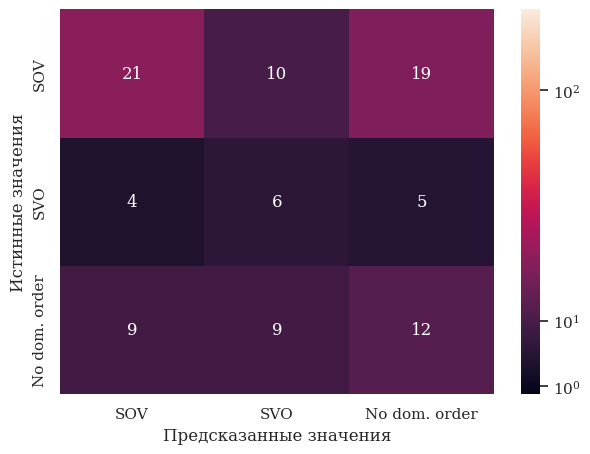

In [20]:
from matplotlib.colors import AsinhNorm
from matplotlib.ticker import MaxNLocator

labels = ['SOV', 'SVO', 'No dom. order']
ax=plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, norm=AsinhNorm(clip=True, vmin=0, vmax=200, linear_width=15), cbar_kws={'ticks': [1,10,100]});

# labels, title and ticks
ax.set_xlabel('Предсказанные значения');
ax.set_ylabel('Истинные значения'); 
ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);
ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)